In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('monthly_revenue.csv')
df = data.copy()

In [3]:
df.head().append(df.tail(5))

,RestaurantName,Month,Year,Revenue,Orders,AverageRevenue
0,Dravid Mansion,12,2019,1421.549981,317,4.48439
1,Dravid Mansion,1,2020,12393.149845,2627,4.71761
2,Dravid Mansion,2,2020,12847.349836,2780,4.62135
3,Dravid Mansion,3,2020,12849.199832,2744,4.68265
4,Dravid Mansion,4,2020,12044.849845,2585,4.65952
91,Tendulkar Palace,3,2022,11843.699841,2492,4.75269
92,Tendulkar Palace,4,2022,13363.299832,2690,4.96777
93,Tendulkar Palace,5,2022,12959.649832,2723,4.75933
94,Tendulkar Palace,6,2022,10881.699847,2262,4.81065
95,Tendulkar Palace,7,2022,11743.349836,2511,4.67676


In [4]:
df.shape

(96, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RestaurantName  96 non-null     object 
 1   Month           96 non-null     int64  
 2   Year            96 non-null     int64  
 3   Revenue         96 non-null     float64
 4   Orders          96 non-null     int64  
 5   AverageRevenue  96 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 4.6+ KB


## Data Preparation

In [6]:
# Create date column for easier visualization
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
df.head(2)

,RestaurantName,Month,Year,Revenue,Orders,AverageRevenue,Date
0,Dravid Mansion,12,2019,1421.549981,317,4.48439,2019-12
1,Dravid Mansion,1,2020,12393.149845,2627,4.71761,2020-1


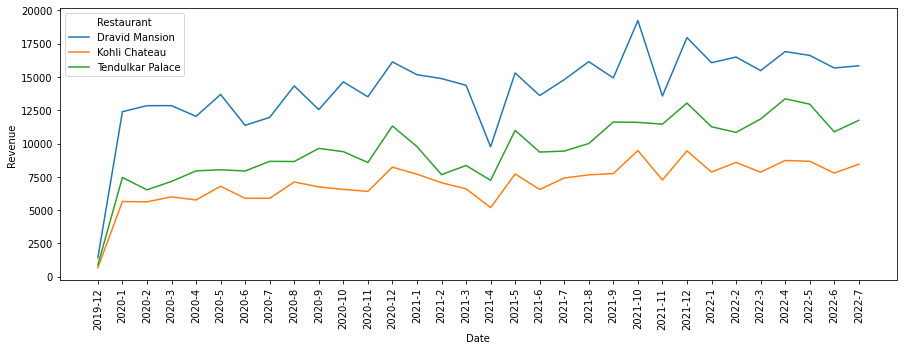

In [7]:
# Monthly revenue by each restaurant

plt.figure(figsize=(15,5))

sns.lineplot(x='Date', y='Revenue', hue='RestaurantName', data=df)
plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.legend(title='Restaurant')

plt.show()

## Train/Test Split

In [8]:
rest_dummies = pd.get_dummies(df.RestaurantName)

In [9]:
df2 = df.merge(rest_dummies, how='left', left_index=True, right_index=True)

In [10]:
df2.head()

,RestaurantName,Month,Year,Revenue,Orders,AverageRevenue,Date,Dravid Mansion,Kohli Chateau,Tendulkar Palace
0,Dravid Mansion,12,2019,1421.549981,317,4.48439,2019-12,1,0,0
1,Dravid Mansion,1,2020,12393.149845,2627,4.71761,2020-1,1,0,0
2,Dravid Mansion,2,2020,12847.349836,2780,4.62135,2020-2,1,0,0
3,Dravid Mansion,3,2020,12849.199832,2744,4.68265,2020-3,1,0,0
4,Dravid Mansion,4,2020,12044.849845,2585,4.65952,2020-4,1,0,0


In [11]:
rest_popped = df2.pop('RestaurantName')
date_popped = df2.pop('Date')

In [12]:
df2.loc[df['Year']==2019]

,Month,Year,Revenue,Orders,AverageRevenue,Dravid Mansion,Kohli Chateau,Tendulkar Palace
0,12,2019,1421.549981,317,4.48439,1,0,0
32,12,2019,671.849992,156,4.30673,0,1,0
64,12,2019,878.349989,184,4.77364,0,0,1


In [13]:
train = df2.loc[df2['Year'] < 2022]
test = df2.loc[df2['Year'] == 2022]

## XGBoost Regressor Model

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [15]:
X_train = train.drop('Revenue', axis=1)
y_train = train['Revenue']

X_test = test.drop('Revenue', axis=1)
y_test = test['Revenue']

In [ ]:
reg = xgb.XGBRegressor(
    n_estimators=1500,
    early_stopping_rounds=50,
    learning_rate=0.01,
    subsample=0.8, 
    max_depth=16,
    gamma=0.80198330585415034, 
    reg_alpha=23.008226565535971, 
    seed=42)

model = reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=True)

Last five rows:

* [1495]	validation_0-rmse:11.04989	validation_1-rmse:355.67603
* [1496]	validation_0-rmse:11.02969	validation_1-rmse:355.66738
* [1497]	validation_0-rmse:11.00572	validation_1-rmse:355.69493
* [1498]	validation_0-rmse:10.99813	validation_1-rmse:355.69583
* [1499]	validation_0-rmse:10.99550	validation_1-rmse:355.69751

In [17]:
test['Prediction'] = reg.predict(X_test)

In [18]:
df_pred = df2.merge(test['Prediction'], how='left', left_index=True, right_index=True)

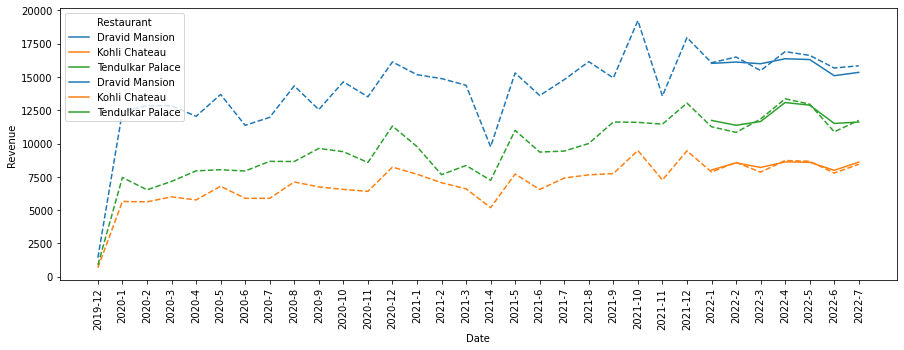

In [19]:
plt.figure(figsize=(15,5))

sns.lineplot(x=date_popped, y='Revenue', hue=rest_popped, data=df_pred, ls='--') # Actual number
sns.lineplot(x=date_popped, y='Prediction', hue=rest_popped, data=df_pred) # Prediction number

plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.legend(title='Restaurant')

plt.show()

In [20]:
df_pred.loc[df['Year'] == 2022] # Prediction result

,Month,Year,Revenue,Orders,AverageRevenue,Dravid Mansion,Kohli Chateau,Tendulkar Palace,Prediction
25,1,2022,16075.299809,3463,4.64202,1,0,0,16026.614258
26,2,2022,16501.599780,3552,4.64572,1,0,0,16123.346680
27,3,2022,15483.549809,3443,4.49711,1,0,0,15997.815430
28,4,2022,16908.499779,3535,4.78317,1,0,0,16372.211914
29,5,2022,16627.299794,3620,4.59318,1,0,0,16313.541016
30,6,2022,15677.899802,3342,4.69117,1,0,0,15098.966797
31,7,2022,15842.749802,3259,4.86123,1,0,0,15349.162109
57,1,2022,7862.599896,1701,4.62234,0,1,0,8014.026855
58,2,2022,8586.699885,1794,4.78634,0,1,0,8549.026367
59,3,2022,7849.149906,1762,4.45468,0,1,0,8205.727539
